In [1]:
from collections import Counter

from jax import random
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.ops.indexing import Vindex

rng_key = random.PRNGKey(42)
seed = random.split(rng_key, 5)

num_samples = 1000
prizes = np.asarray(["goat1", "goat2", "car"])
doors = np.asarray(["door1", "door2", "door3"])


## Modelling approach 1


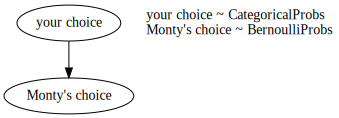

In [2]:
def monty_hall_1(monty_choice = None):
    theta_you = numpyro.param("theta (your choice)", jnp.ones(3)/3)
    your_choice = numpyro.sample("your choice", dist.Categorical(theta_you), infer={"enumerate": "parallel"})
    
    theta_monty = numpyro.param("theta (Monty's choice)", jnp.asarray([1, 0, 0.5]))
    numpyro.sample("Monty's choice", dist.Bernoulli(Vindex(theta_monty)[your_choice]), infer={"enumerate": "parallel"}, obs=monty_choice)
    
monty_hall_1_predict = Predictive(monty_hall_1, num_samples=num_samples, infer_discrete=True)

display(numpyro.render_model(monty_hall_1, render_distributions=True, render_params=False))


In [3]:
predictions = monty_hall_1_predict(seed[0])

Counter(prizes[predictions["your choice"]])


Counter({'car': 321, 'goat2': 340, 'goat1': 339})

In [4]:
predictions = monty_hall_1_predict(seed[0], monty_choice=1)

Counter(prizes[predictions["your choice"]])


Counter({'goat1': 630, 'car': 370})

## Modelling approach 2


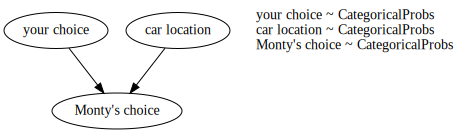

In [5]:
def monty_hall_2(your_choice = None, monty_choice = None):
    theta_you = numpyro.param("theta (your choice)", jnp.ones(3)/3)
    your_choice = numpyro.sample("your choice", dist.Categorical(theta_you), infer={"enumerate": "parallel"}, obs=your_choice)
    
    theta_car = numpyro.param("theta (car location)", jnp.ones(3)/3)
    car_location = numpyro.sample("car location", dist.Categorical(theta_car), infer={"enumerate": "parallel"})
    
    theta_monty = numpyro.param(
        "theta (Monty's choice)", 
        jnp.asarray(
            [
                [[0, 0.5, 0.5], [0, 0, 1], [0, 1, 0]],
                [[0, 0, 1], [0.5, 0, 0.5], [1, 0, 0]],
                [[0, 1, 0], [1, 0, 0], [0.5, 0.5, 0]],
            ]
        )
    )
    numpyro.sample("Monty's choice", dist.Categorical(Vindex(theta_monty)[your_choice, car_location]), infer={"enumerate": "parallel"}, obs=monty_choice)
    
monty_hall_2_predict = Predictive(monty_hall_2, num_samples=num_samples, infer_discrete=True)

display(numpyro.render_model(monty_hall_2, render_distributions=True, render_params=False))


In [6]:
predictions = monty_hall_2_predict(seed[0])

Counter(doors[predictions["car location"]])


Counter({'door1': 324, 'door3': 349, 'door2': 327})

In [7]:
predictions = monty_hall_2_predict(seed[0], monty_choice=1)

Counter(doors[predictions["car location"]])


Counter({'door1': 495, 'door3': 505})

In [8]:
predictions = monty_hall_2_predict(seed[0], your_choice=0, monty_choice=1)

Counter(doors[predictions["car location"]])


Counter({'door3': 659, 'door1': 341})